**本文已加入 [**🚀 Python AI 计划**](https://github.com/kzbkzb/Python-AI)，从一个Python小白到一个AI大神，你所需要的所有知识都在 [这里](https://github.com/kzbkzb/Python-AI) 了。**
***

- **作者**：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- **数据**：公众号内回复 `DL+29`可以获取数据
- **代码**：全部代码已放入文中，也可以去我的 [GitHub](https://github.com/kzbkzb/Python-AI) 上下载

数据中一共包含1462张数据图片，分为浮标、游轮、渡船、货船、贡多拉、充气船、皮划艇、纸船、帆船等9类。我们将通过`ResNet50`算法实现这9类目标的识别，最后的准确率为`87.0%。`

🥇 需要 **项目定制**、**毕设辅导** 的同学可以加我V.信：mtyjkh_

我的环境：

- 语言环境：Python3.8
- 编译器：Jupyter lab
- 深度学习环境：TensorFlow2.4.1

我们的代码流程图如下所示：
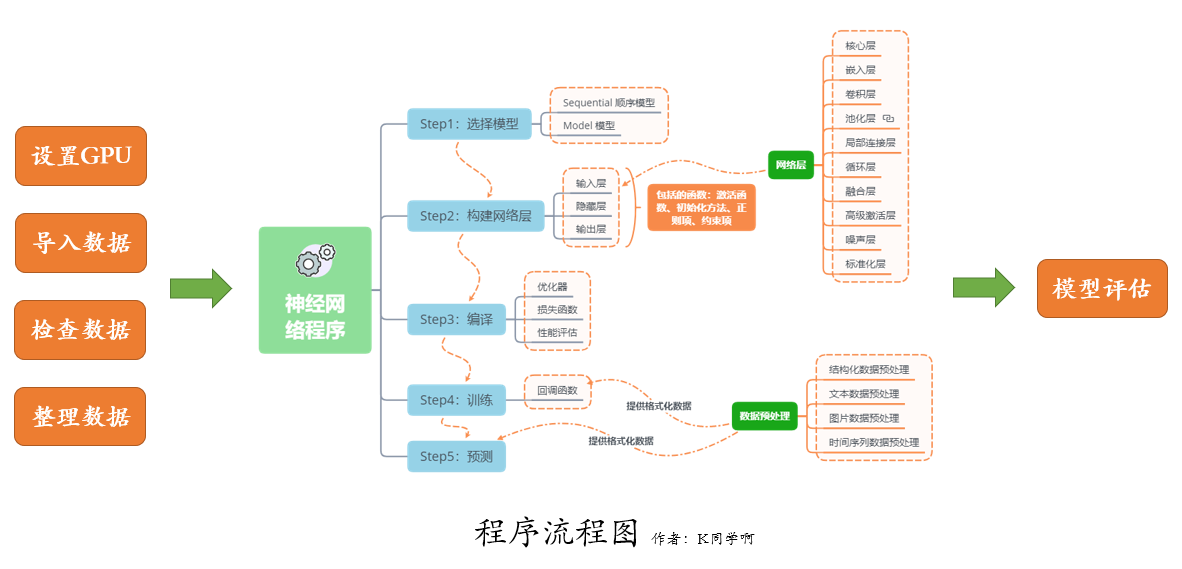

# 一、设置GPU

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")
    
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")#忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 二、导入数据

## 1. 导入数据

In [2]:
import pathlib

data_dir = "./29-data/"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("图片总数为：",image_count)

图片总数为： 1462


In [3]:
batch_size = 16
img_height = 224
img_width  = 224

In [4]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789

通过该方法导入数据时，会同时打乱数据
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1462 files belonging to 9 classes.
Using 1316 files for training.


In [5]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789

通过该方法导入数据时，会同时打乱数据
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1462 files belonging to 9 classes.
Using 146 files for validation.


In [6]:
class_names = train_ds.class_names
print("数据类别有：",class_names)
print("需要识别的船一共有%d类"%len(class_names))

数据类别有： ['buoy', 'cruise ship', 'ferry boat', 'freight boat', 'gondola', 'inflatable boat', 'kayak', 'paper boat', 'sailboat']
需要识别的船一共有9类


## 2. 检查数据

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


## 3. 配置数据集

- **shuffle() ：** 打乱数据。
- **prefetch() ：** 预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache() ：** 将数据集缓存到内存当中，加速运行

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()
    .map(train_preprocessing)    # 这里可以设置预处理函数
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .map(train_preprocessing)    # 这里可以设置预处理函数
    .prefetch(buffer_size=AUTOTUNE)
)

## 4. 数据可视化

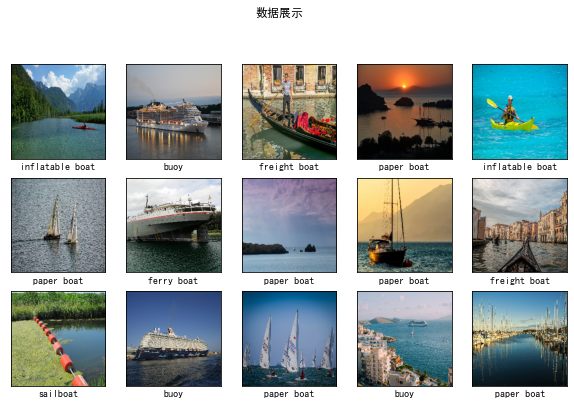

In [9]:
plt.figure(figsize=(10, 8))  # 图形的宽为10高为5
plt.suptitle("数据展示")

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # 显示图片
        plt.imshow(images[i])
        # 显示标签
        plt.xlabel(class_names[labels[i]-1])

plt.show()

# 三、构建模型

在这次训练的过程中我发现一个有趣的现象：当我使用复杂的网络时，训练效果不是很理想；当采用相对简单的网络时，效果反而还不错。

In [10]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

# 加载预训练模型
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

for layer in base_model.layers:
    layer.trainable = True
    
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(class_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

# 四、编译

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 五、训练模型

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 50
PATIENCE  = 5
VERBOSE   = 1

# 设置动态学习率
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

# 设置早停
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

# 
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [13]:
train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[earlystopper, checkpointer])

Epoch 1/50
83/83 [==============================] - 17s 109ms/step - loss: 1.8596 - accuracy: 0.3625 - val_loss: 2.2435 - val_accuracy: 0.3699

Epoch 00001: val_accuracy improved from -inf to 0.36986, saving model to best_model.h5
Epoch 2/50
83/83 [==============================] - 8s 94ms/step - loss: 1.5476 - accuracy: 0.5190 - val_loss: 2.1825 - val_accuracy: 0.1575

Epoch 00002: val_accuracy did not improve from 0.36986
Epoch 3/50
83/83 [==============================] - 7s 85ms/step - loss: 1.4120 - accuracy: 0.5813 - val_loss: 2.1147 - val_accuracy: 0.3699

Epoch 00003: val_accuracy did not improve from 0.36986
Epoch 4/50
83/83 [==============================] - 7s 79ms/step - loss: 1.2929 - accuracy: 0.6489 - val_loss: 2.0797 - val_accuracy: 0.2808

Epoch 00004: val_accuracy did not improve from 0.36986
Epoch 5/50
83/83 [==============================] - 7s 78ms/step - loss: 1.2369 - accuracy: 0.6725 - val_loss: 2.0125 - val_accuracy: 0.4247

Epoch 00005: val_accuracy improved f

# 六、评估模型

## 1. Accuracy与Loss图

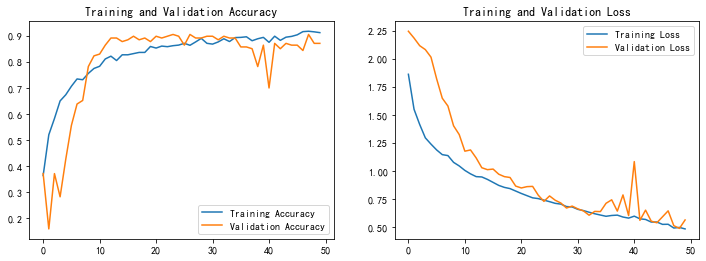

In [14]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

可以看出模型的波动还是蛮大的，这主要是由于数据较少导致了（1462张图片9个类别），在数据扩充后，情况会得到有效改善的。

## 2. 混淆矩阵

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [16]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

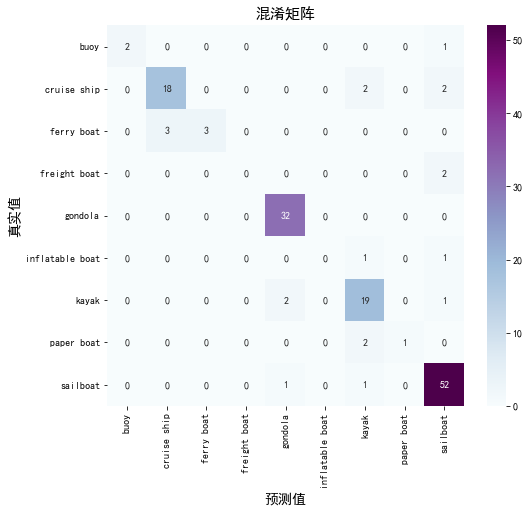

In [17]:
plot_cm(val_label, val_pre)

## 3. 各项指标评估

In [18]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names)) 
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
    
test_accuracy_report(model)

                 precision    recall  f1-score   support

           buoy       1.00      0.67      0.80         3
    cruise ship       0.86      0.82      0.84        22
     ferry boat       1.00      0.50      0.67         6
   freight boat       0.00      0.00      0.00         2
        gondola       0.91      1.00      0.96        32
inflatable boat       0.00      0.00      0.00         2
          kayak       0.76      0.86      0.81        22
     paper boat       1.00      0.33      0.50         3
       sailboat       0.88      0.96      0.92        54

       accuracy                           0.87       146
      macro avg       0.71      0.57      0.61       146
   weighted avg       0.85      0.87      0.85       146

Loss function: 0.5606985688209534, accuracy: 0.8698630332946777
